<a href="https://colab.research.google.com/github/dev-tusha-soni/Distributed-Healthcare-Data-Analysis-Using-Apache-Spark/blob/main/Distributed_Healthcare_Data_Analysis_Using_Apache_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
w# **Step 1: Install and Configure Spark**
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark

In [ ]:
# **Step 2: Set Environment Variables**
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-3.4.1-bin-hadoop3'

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Healthcare Data Analysis").getOrCreate()


In [ ]:
# **Step 3: Upload and Load Data**
from google.colab import files
import pandas as pd

uploaded = files.upload()
df = pd.read_csv(list(uploaded.keys())[0])
df.head()

Saving heart.csv to heart.csv


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
# **Step 4: Convert Pandas DataFrame to Spark DataFrame**
spark_df = spark.createDataFrame(df)
spark_df.show(5)


+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|    0.0|      Up|           0|
+---+---+-------------+---------+-----------+---------+-

In [ ]:
# **Step 5: Data Cleaning and Preprocessing**
from pyspark.sql.functions import col


In [ ]:
# Convert Columns to Integer
data_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']
for column in data_columns:
    spark_df = spark_df.withColumn(column, col(column).cast('int'))

spark_df.describe().show()

+-------+------------------+----+-------------+------------------+------------------+-------------------+----------+------------------+--------------+------------------+--------+------------------+
|summary|               Age| Sex|ChestPainType|         RestingBP|       Cholesterol|          FastingBS|RestingECG|             MaxHR|ExerciseAngina|           Oldpeak|ST_Slope|      HeartDisease|
+-------+------------------+----+-------------+------------------+------------------+-------------------+----------+------------------+--------------+------------------+--------+------------------+
|  count|               918| 918|          918|               918|               918|                918|       918|               918|           918|               918|     918|               918|
|   mean|53.510893246187365|null|         null|132.39651416122004| 198.7995642701525|0.23311546840958605|      null|136.80936819172112|          null|0.8873638344226581|    null|0.5533769063180828|
| stddev| 

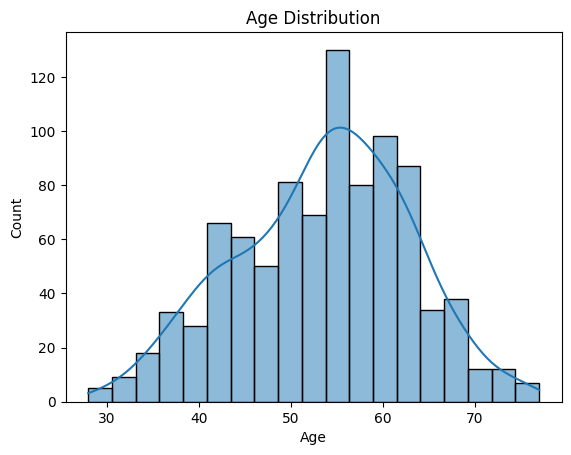

In [ ]:
# **Step 6: Data Visualization**
import seaborn as sns
import matplotlib.pyplot as plt

df_pd = spark_df.toPandas()
sns.histplot(df_pd['Age'], kde=True)
plt.title('Age Distribution')
plt.show()

In [ ]:
# **Step 7: Feature Engineering**
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['Age', 'RestingBP', 'Cholesterol', 'MaxHR'], outputCol='features')
data = assembler.transform(spark_df).select('features', 'HeartDisease')
data.show(5)

+--------------------+------------+
|            features|HeartDisease|
+--------------------+------------+
|[40.0,140.0,289.0...|           0|
|[49.0,160.0,180.0...|           1|
|[37.0,130.0,283.0...|           0|
|[48.0,138.0,214.0...|           1|
|[54.0,150.0,195.0...|           0|
+--------------------+------------+
only showing top 5 rows



In [ ]:
# **Step 8: Train-Test Split**
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

In [ ]:
# **Step 9: Train Logistic Regression Model**
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol='HeartDisease', featuresCol='features', maxIter=20, regParam=0.01)
model = lr.fit(train_data)
print("Model training completed successfully.")


Model training completed successfully.


In [ ]:
# **Step 10: Model Prediction**
predictions = model.transform(test_data)
predictions.select('features', 'HeartDisease', 'prediction', 'probability').show(10)

+--------------------+------------+----------+--------------------+
|            features|HeartDisease|prediction|         probability|
+--------------------+------------+----------+--------------------+
|[29.0,120.0,243.0...|           0|       0.0|[0.80117240644316...|
|[31.0,100.0,219.0...|           0|       0.0|[0.74894206367017...|
|[35.0,120.0,308.0...|           0|       0.0|[0.88299700461408...|
|[36.0,110.0,0.0,1...|           1|       1.0|[0.35491776999923...|
|[36.0,112.0,340.0...|           0|       0.0|[0.90637670996154...|
|[36.0,120.0,166.0...|           0|       0.0|[0.81845075467853...|
|[36.0,120.0,267.0...|           1|       0.0|[0.78057556731110...|
|[37.0,130.0,315.0...|           0|       0.0|[0.78238446503851...|
|[38.0,120.0,275.0...|           0|       0.0|[0.58290668130877...|
|[38.0,135.0,0.0,1...|           1|       1.0|[0.47671523485656...|
+--------------------+------------+----------+--------------------+
only showing top 10 rows



In [ ]:
# **Step 11: Model Evaluation**
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='HeartDisease', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

f1_evaluator = MulticlassClassificationEvaluator(labelCol='HeartDisease', predictionCol='prediction', metricName='f1')
f1_score = f1_evaluator.evaluate(predictions)
print(f"F1 Score: {f1_score:.2f}")

Test Accuracy: 68.72%
F1 Score: 0.69


In [ ]:
# **Step 12: Model Coefficients and Intercept**
print("Coefficients:", model.coefficients)
print("Intercept:", model.intercept)

Coefficients: [0.02952938325479251,0.006582742179192176,-0.003420469016318247,-0.029116500399476095]
Intercept: 2.4498947812547565


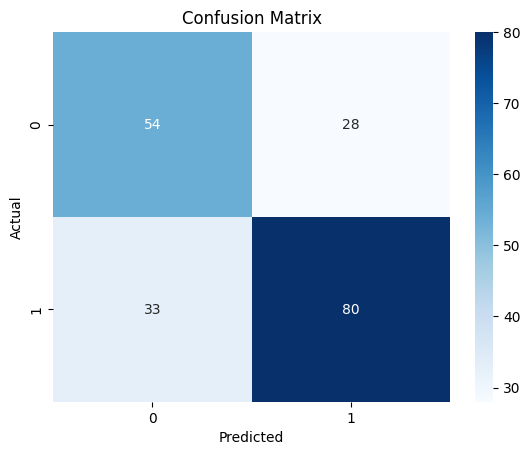

In [ ]:
# **Step 13: Confusion Matrix Visualization**
import numpy as np
from sklearn.metrics import confusion_matrix

predictions_pd = predictions.select('HeartDisease', 'prediction').toPandas()
cm = confusion_matrix(predictions_pd['HeartDisease'], predictions_pd['prediction'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# **Step 14: Save the Model**
model_path = "/content/logistic_regression_model"
model.save(model_path)
print("Model saved successfully.")


Model saved successfully.
